# Few Shot GPT Prompting

In [1]:
import pandas as pd
import os
from IPython.display import Image, display
from openai import OpenAI
import base64
import dotenv
from dotenv import load_dotenv
import gpt_utils

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
dotenv.load_dotenv()
api_key = os.environ["OPENAI_API_KEY"]
client = OpenAI()

## Load Test and Prompt Sets

In [4]:
df_test = pd.read_csv("data/test-df.csv")

In [5]:
prompt_df = pd.read_csv("data/prompt-df.csv")

In [6]:
prompt_df.head()

,Class,image,Class Name,image_path,Ground Truth Year
0,97,05056.jpg,Dodge Charger SRT-8 2009,/scratch/shared/image_ai_HHT_data/images/05056.jpg,2009
1,97,03096.jpg,Dodge Charger SRT-8 2009,/scratch/shared/image_ai_HHT_data/images/03096.jpg,2009
2,97,05768.jpg,Dodge Charger SRT-8 2009,/scratch/shared/image_ai_HHT_data/images/05768.jpg,2009
3,97,07030.jpg,Dodge Charger SRT-8 2009,/scratch/shared/image_ai_HHT_data/images/07030.jpg,2009
4,97,07107.jpg,Dodge Charger SRT-8 2009,/scratch/shared/image_ai_HHT_data/images/07107.jpg,2009


In [7]:
prompt_df.shape

(20, 5)

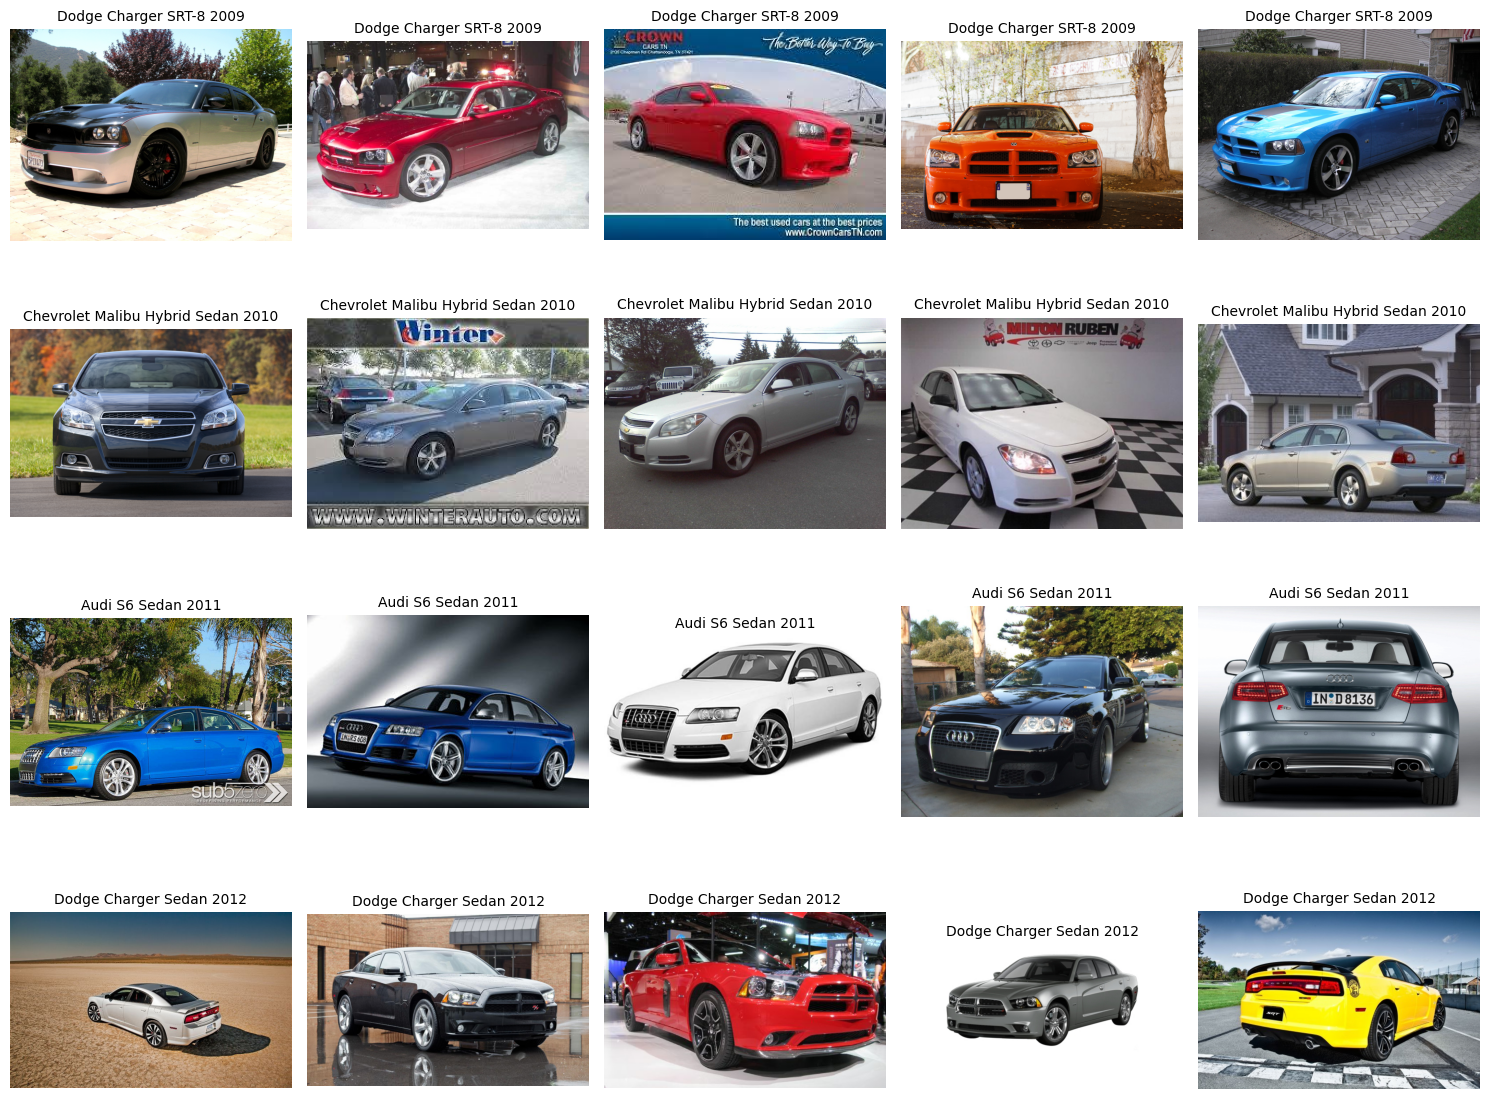

In [8]:
gpt_utils.show_prompt_images(prompt_df)

## Load Data 
[Stanford Cars dataset](https://paperswithcode.com/dataset/stanford-cars).

In [9]:
df = pd.read_csv('/scratch/shared/image_ai_HHT_data/train.csv', 
                 usecols=['image', 'Class', 'Class Name'])

In [10]:
image_dir = '/scratch/shared/image_ai_HHT_data/images/' 
# Add image path column
df['image_path'] = image_dir + df['image']

## Make Prompt

In [11]:
model = "gpt-4o-2024-08-06"

In [12]:
prompt_df.head()

,Class,image,Class Name,image_path,Ground Truth Year
0,97,05056.jpg,Dodge Charger SRT-8 2009,/scratch/shared/image_ai_HHT_data/images/05056.jpg,2009
1,97,03096.jpg,Dodge Charger SRT-8 2009,/scratch/shared/image_ai_HHT_data/images/03096.jpg,2009
2,97,05768.jpg,Dodge Charger SRT-8 2009,/scratch/shared/image_ai_HHT_data/images/05768.jpg,2009
3,97,07030.jpg,Dodge Charger SRT-8 2009,/scratch/shared/image_ai_HHT_data/images/07030.jpg,2009
4,97,07107.jpg,Dodge Charger SRT-8 2009,/scratch/shared/image_ai_HHT_data/images/07107.jpg,2009


In [13]:
# make class_image_dict
# Group the DataFrame by 'Class Name' and collect image paths
class_image_dict = prompt_df.groupby('Class Name')['image_path'].apply(list).to_dict()

In [14]:
class_image_dict

{'Audi S6 Sedan 2011': ['/scratch/shared/image_ai_HHT_data/images/06830.jpg',
  '/scratch/shared/image_ai_HHT_data/images/05212.jpg',
  '/scratch/shared/image_ai_HHT_data/images/00956.jpg',
  '/scratch/shared/image_ai_HHT_data/images/02441.jpg',
  '/scratch/shared/image_ai_HHT_data/images/04237.jpg'],
 'Chevrolet Malibu Hybrid Sedan 2010': ['/scratch/shared/image_ai_HHT_data/images/04879.jpg',
  '/scratch/shared/image_ai_HHT_data/images/08119.jpg',
  '/scratch/shared/image_ai_HHT_data/images/07432.jpg',
  '/scratch/shared/image_ai_HHT_data/images/01961.jpg',
  '/scratch/shared/image_ai_HHT_data/images/07563.jpg'],
 'Dodge Charger SRT-8 2009': ['/scratch/shared/image_ai_HHT_data/images/05056.jpg',
  '/scratch/shared/image_ai_HHT_data/images/03096.jpg',
  '/scratch/shared/image_ai_HHT_data/images/05768.jpg',
  '/scratch/shared/image_ai_HHT_data/images/07030.jpg',
  '/scratch/shared/image_ai_HHT_data/images/07107.jpg'],
 'Dodge Charger Sedan 2012': ['/scratch/shared/image_ai_HHT_data/imag

In [15]:
num_classes = len(set(df_test['Class Name']))
# Dynamically construct the system prompt
sysprompt = f"You are an assistant that identifies car's year in images. Here are examples of {num_classes} car classes with images to help you."

# Predict Year of the Car in the Image with Few Shot Prompting

In [23]:
# Initialize an empty list to store responses
responses = []

# Loop over the images
for idx, row in df_test.iterrows():
    print(f'i: {idx}')
    print(row)
    image_filename = row['image']
    
    # Construct the full path to the image
    image_path = os.path.join(f'{image_dir}', image_filename)  
    print(f'image_path: {image_path}')
    
    # Check if the image file exists
    if not os.path.isfile(image_path):
        print(f"Image file not found: {image_path}")
        responses.append(None)
        continue
    
    # Encode the image
    encoded_image = gpt_utils.encode_image(image_path)
    
    # Prepare the image content for the API
    image_content = {
        "type": "image_url",
        "image_url": {
            "url": f"data:image/png;base64,{encoded_image}"
        }
    }
    messages = [ { "role": "system",
                "content": [
                    {"type": "text", "text": sysprompt} ] },
            # For each car class, show its images with a label
            *[{
                    "role": "user",
                    "content": [
                        {"type": "text", "text": f"The following images show examples of {class_name}."},
                        *gpt_utils.generate_image_objects(image_paths)
                    ]} 
                for class_name, image_paths in class_image_dict.items()
            ],
           {"role": "user", "content": [
                    {
                        "type": "text",
                        "text": "What is the year of the car in the image?"
                    },
                    image_content
            ]} ]                
    
    try:
        # Send the request to the GPT model
        completion = client.chat.completions.create(
            model = model,  
            messages = messages
        )
        
        # Extract the assistant's reply
        reply = completion.choices[0].message.content
        responses.append(reply)
        print(f'response: {reply}')
        
    except Exception as e:
        print(f"An error occurred: {e}")
        responses.append(None)

i: 0
Class                                                                67
image                                                         02502.jpg
Class Name                           Chevrolet Malibu Hybrid Sedan 2010
image_path           /scratch/shared/image_ai_HHT_data/images/02502.jpg
Ground Truth Year                                                  2010
Name: 0, dtype: object
image_path: /scratch/shared/image_ai_HHT_data/images/02502.jpg
response: The car in the image is a Chevrolet Malibu Hybrid Sedan from the year 2010.
i: 1
Class                                                                20
image                                                         00600.jpg
Class Name                                           Audi S6 Sedan 2011
image_path           /scratch/shared/image_ai_HHT_data/images/00600.jpg
Ground Truth Year                                                  2011
Name: 1, dtype: object
image_path: /scratch/shared/image_ai_HHT_data/images/00600.jpg
response: Th

In [24]:
# Add the responses to the DataFrame
df_test['GPT_Response'] = responses

In [25]:
df_test.head()

,Class,image,Class Name,image_path,Ground Truth Year,GPT_Response
0,67,02502.jpg,Chevrolet Malibu Hybrid Sedan 2010,/scratch/shared/image_ai_HHT_data/images/02502.jpg,2010,The car in the image is a Chevrolet Malibu Hybrid Sedan from the year 2010.
1,20,00600.jpg,Audi S6 Sedan 2011,/scratch/shared/image_ai_HHT_data/images/00600.jpg,2011,The car in the image is an Audi S6 Sedan from the year 2011.
2,67,03998.jpg,Chevrolet Malibu Hybrid Sedan 2010,/scratch/shared/image_ai_HHT_data/images/03998.jpg,2010,"The car in the image is a Chevrolet Malibu, likely from the 2010 model year."
3,97,00054.jpg,Dodge Charger SRT-8 2009,/scratch/shared/image_ai_HHT_data/images/00054.jpg,2009,The car in the image is a Dodge Charger SRT-8 from 2009.
4,96,04211.jpg,Dodge Charger Sedan 2012,/scratch/shared/image_ai_HHT_data/images/04211.jpg,2012,The car in the image is a Dodge Charger Sedan from 2012.


In [26]:
df_test.to_csv("results/few-shot-responses.csv", index=False)

## Post-process and Compute Accuracy

In [27]:
df_test = pd.read_csv("results/few-shot-responses.csv")

In [28]:
df_test.head()

,Class,image,Class Name,image_path,Ground Truth Year,GPT_Response
0,67,02502.jpg,Chevrolet Malibu Hybrid Sedan 2010,/scratch/shared/image_ai_HHT_data/images/02502.jpg,2010,The car in the image is a Chevrolet Malibu Hybrid Sedan from the year 2010.
1,20,00600.jpg,Audi S6 Sedan 2011,/scratch/shared/image_ai_HHT_data/images/00600.jpg,2011,The car in the image is an Audi S6 Sedan from the year 2011.
2,67,03998.jpg,Chevrolet Malibu Hybrid Sedan 2010,/scratch/shared/image_ai_HHT_data/images/03998.jpg,2010,"The car in the image is a Chevrolet Malibu, likely from the 2010 model year."
3,97,00054.jpg,Dodge Charger SRT-8 2009,/scratch/shared/image_ai_HHT_data/images/00054.jpg,2009,The car in the image is a Dodge Charger SRT-8 from 2009.
4,96,04211.jpg,Dodge Charger Sedan 2012,/scratch/shared/image_ai_HHT_data/images/04211.jpg,2012,The car in the image is a Dodge Charger Sedan from 2012.


In [29]:
df_test = gpt_utils.is_prediction_correct(df_test)

In [30]:
df_test.head()

,Class,image,Class Name,image_path,Ground Truth Year,GPT_Response,Predicted Years,Correct Prediction
0,67,02502.jpg,Chevrolet Malibu Hybrid Sedan 2010,/scratch/shared/image_ai_HHT_data/images/02502.jpg,2010,The car in the image is a Chevrolet Malibu Hybrid Sedan from the year 2010.,[2010],True
1,20,00600.jpg,Audi S6 Sedan 2011,/scratch/shared/image_ai_HHT_data/images/00600.jpg,2011,The car in the image is an Audi S6 Sedan from the year 2011.,[2011],True
2,67,03998.jpg,Chevrolet Malibu Hybrid Sedan 2010,/scratch/shared/image_ai_HHT_data/images/03998.jpg,2010,"The car in the image is a Chevrolet Malibu, likely from the 2010 model year.",[2010],True
3,97,00054.jpg,Dodge Charger SRT-8 2009,/scratch/shared/image_ai_HHT_data/images/00054.jpg,2009,The car in the image is a Dodge Charger SRT-8 from 2009.,[2009],True
4,96,04211.jpg,Dodge Charger Sedan 2012,/scratch/shared/image_ai_HHT_data/images/04211.jpg,2012,The car in the image is a Dodge Charger Sedan from 2012.,[2012],True


In [31]:
accuracy = df_test['Correct Prediction'].mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 95.00%


In [ ]:
# Analyze which car models have higher prediction rates (predicted correct year)

Correct Prediction                  False  True  Total  Accuracy
Class Name                                                      
Audi S6 Sedan 2011                    1.0   4.0    5.0       0.8
Chevrolet Malibu Hybrid Sedan 2010    0.0   5.0    5.0       1.0
Dodge Charger SRT-8 2009              0.0   5.0    5.0       1.0
Dodge Charger Sedan 2012              0.0   5.0    5.0       1.0


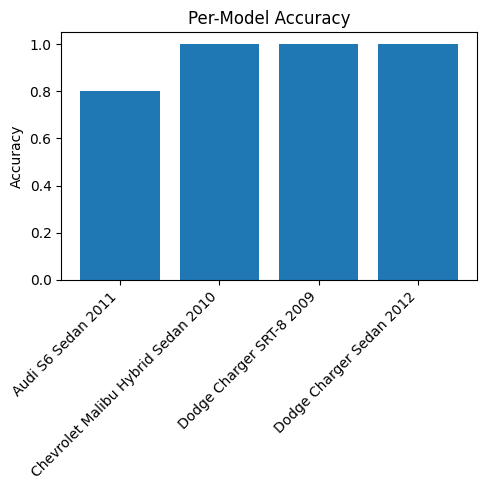

In [32]:
gpt_utils.plot_per_model_accuracy(df_test)